<a href="https://colab.research.google.com/github/hsss/pytorch_tutorial/blob/master/example/01_MNIST_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

0it [00:00, ?it/s]

9920512it [00:01, 9227218.41it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 138699.03it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2288022.15it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 52222.34it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [0]:

# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h)    
    
    
model = Model()
if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:

EPOCHS = 5
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu()), 
                end='')
    # Eval
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu(),
        accuracy*100,
        end=''))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


 Train Epoch: 1/5 [57664/60000 (96%)]	Loss: 0.033396

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 0.006001	 Test Accuracy: 0.0000%
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 0.019539	 Test Accuracy: 0.0000%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 0.005376	 Test Accuracy: 0.0000%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 0.024753	 Test Accuracy: 0.0000%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 0.004277	 Test Accuracy: 0.0000%


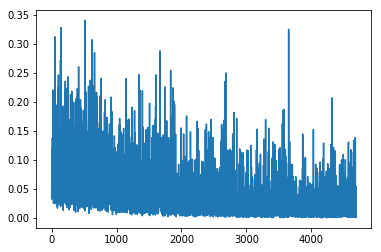

In [10]:
plot(losses)

In [11]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy*100)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: tensor(0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
